In [7]:
import os
import glob

# Базовая директория
base_dir = "/mnt/mydisk/freesurfer/simon"

# Поиск всех файлов aparc.DKTatlas+aseg.mgz только в подпапках */mri/
dkt_files = []
for root, dirs, files in os.walk(base_dir):
    if not root.endswith('/mri'):
        continue
    for file in files:
        if file == "aparc.DKTatlas+aseg.mgz":
            dkt_files.append(os.path.join(root, file))
    
    # Если файл не найден в текущей папке, добавляем имя папки в список
    if not any(file == "aparc.DKTatlas+aseg.mgz" for file in files):
        print(f"Файл aparc.DKTatlas+aseg.mgz не найден в папке: {root}")
        

# Вывод найденных файлов
print(f"Найдено {len(dkt_files)} файлов aparc.DKTatlas+aseg.mgz:")
# for file in dkt_files:
    # print(file)

Файл aparc.DKTatlas+aseg.mgz не найден в папке: /mnt/mydisk/freesurfer/simon/ses-011/mri
Найдено 69 файлов aparc.DKTatlas+aseg.mgz:


In [ ]:
import numpy as np
import nibabel as nib
from collections import defaultdict
import pandas as pd

# Словарь для хранения уникальных значений для каждого файла
unique_values = {}
# Словарь для группировки файлов по количеству уникальных значений
files_by_unique_count = defaultdict(list)
# Словарь для хранения суммы вокселей по каждой метке для всех файлов
all_labels_voxel_counts = defaultdict(list)

print("Анализ уникальных значений в файлах aparc.DKTatlas+aseg.mgz и подсчет суммы вокселей для всех уникальных меток:")
for file_path in dkt_files:
    # Загрузка файла .mgz с помощью nibabel
    img = nib.load(file_path)
    # Преобразование данных в numpy массив
    data = np.array(img.dataobj)
    
    # Получение уникальных значений
    uniques = np.unique(data)
    # Сохранение уникальных значений для этого файла
    unique_values[file_path] = uniques
    # Группировка файлов по количеству уникальных значений
    files_by_unique_count[len(uniques)].append(file_path)
    
    # Получение имени субъекта
    subject_dir = file_path.split('/mri/')[0]
    subject_name = os.path.basename(subject_dir)
    
    # Подсчет количества вокселей для каждой уникальной метки
    label_counts = {}
    for label in uniques:
        count = np.sum(data == label)
        label_counts[int(label)] = count
        all_labels_voxel_counts[int(label)].append((subject_name, count))
    
    # Вывод информации о файле
    print(f"Файл: {subject_name}, количество уникальных значений: {len(uniques)}")
    
    # Вывод количества вокселей для меток [17, 18, 53, 54] как пример
    target_labels = [17, 18, 53, 54]
    for label in target_labels:
        if label in label_counts:
            print(f"  Метка {label}: {label_counts[label]} вокселей")
        else:
            print(f"  Метка {label} отсутствует в файле")

# Проверка, одинаковое ли количество уникальных значений во всех файлах
if len(files_by_unique_count) == 1:
    print("\nВсе файлы имеют одинаковое количество уникальных значений.")
    unique_count = list(files_by_unique_count.keys())[0]
    print(f"Количество уникальных значений: {unique_count}")
else:
    print("\nОбнаружены различия в количестве уникальных значений:")
    for count, files in files_by_unique_count.items():
        print(f"\nКоличество уникальных значений: {count}, количество файлов: {len(files)}")
        print("Примеры файлов:")
        for file in files[:3]:  # Показываем только первые 3 файла для каждой группы
            subject_dir = file.split('/mri/')[0]
            subject_name = os.path.basename(subject_dir)
            print(f"  - {subject_name}")
        if len(files) > 3:
            print(f"  ... и еще {len(files) - 3} файлов")
            
    # Проверка, совпадают ли сами уникальные значения в файлах с одинаковым количеством
    for count, files in files_by_unique_count.items():
        if len(files) > 1:
            print(f"\nСравнение уникальных значений для группы с {count} уникальными значениями:")
            reference_values = unique_values[files[0]]
            all_match = True
            
            for file in files[1:]:
                if not np.array_equal(unique_values[file], reference_values):
                    all_match = False
                    print(f"Файл {os.path.basename(file.split('/mri/')[0])} имеет отличающиеся значения")
            
            if all_match:
                print(f"Все файлы в группе с {count} уникальными значениями содержат одинаковые значения")

# Создаем DataFrame для статистики по всем меткам
all_labels_stats = []
for label, counts in all_labels_voxel_counts.items():
    if counts:  # Проверяем, что список не пустой
        count_values = [c[1] for c in counts]  # Извлекаем только значения счетчиков
        stats = {
            'label': label,
            'min': np.min(count_values),
            'max': np.max(count_values),
            'mean': np.mean(count_values),
            'median': np.median(count_values),
            'std': np.std(count_values),
            'count': len(counts)  # Количество файлов, содержащих эту метку
        }
        all_labels_stats.append(stats)

# Создаем DataFrame и сортируем по метке
stats_df = pd.DataFrame(all_labels_stats)
if not stats_df.empty:
    stats_df = stats_df.sort_values('label')
    
    # Вывод статистики для всех меток
    print("\nСтатистика по количеству вокселей для всех уникальных меток:")
    print(stats_df)
else:
    print("\nНе удалось собрать статистику по меткам.")

In [14]:
stats_df[stats_df['label'] == 17]

,label,min,max,mean,median,std,count
13,17,4888,5312,5092.478261,5092.0,110.310183,69


In [15]:
stats_df[stats_df['label'] == 53]

,label,min,max,mean,median,std,count
14,18,1942,2316,2125.144928,2122.0,73.442726,69


In [16]:
stats_df[stats_df['label'] == 54]

,label,min,max,mean,median,std,count
28,54,2046,2354,2220.333333,2234.0,71.062468,69


In [20]:
!pip install scipy


     |████████████████████████████████| 34.5 MB 4.9 MB/s eta 0:00:01


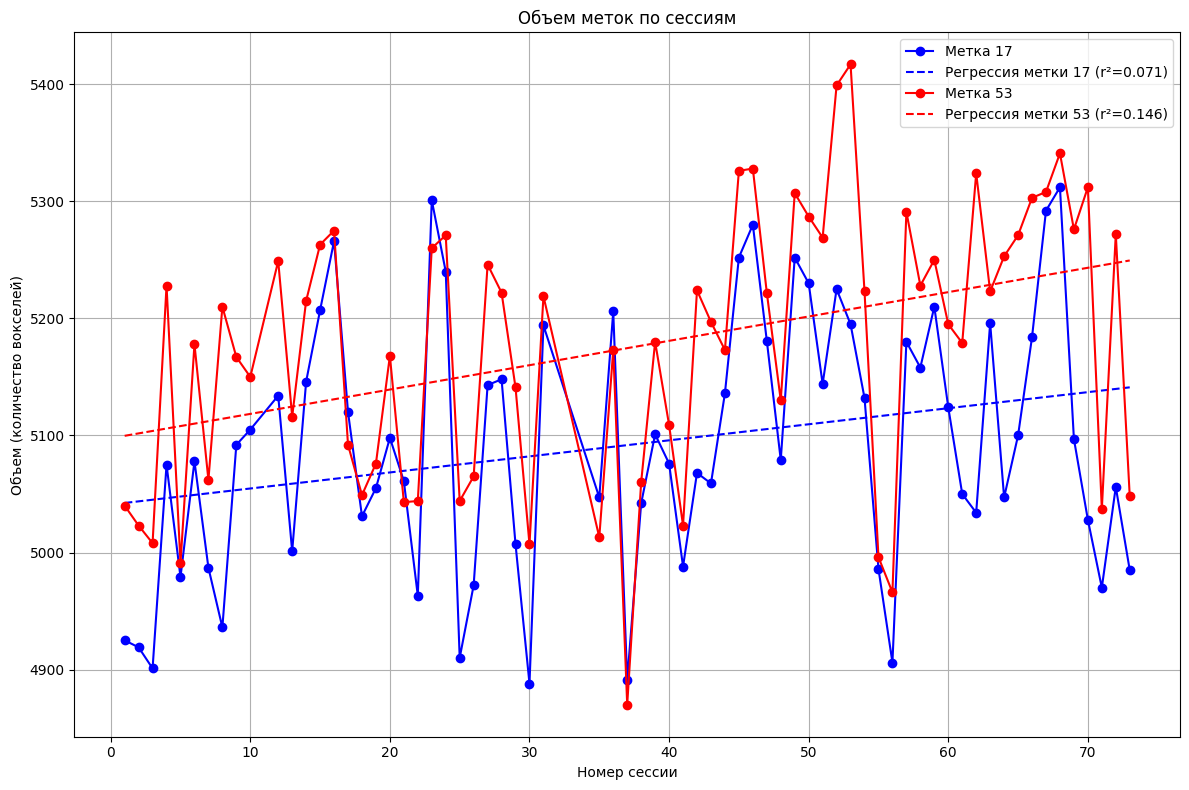

In [21]:
# Создаем график для отображения объемов меток 17, 18, 53, 54 по сессиям
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Выбираем нужные метки
target_labels = [17, 53, ]
labels_data = {}

# Собираем данные для каждой метки
for label in target_labels:
    label_data = stats_df[stats_df['label'] == label]
    if not label_data.empty:
        # Получаем список кортежей (имя_файла, количество_вокселей) для данной метки
        label_counts = all_labels_voxel_counts.get(label, [])
        
        # Извлекаем номера сессий из имен файлов
        sessions = []
        volumes = []
        
        for file_path, count in label_counts:
            # Извлекаем имя файла из пути
            file_name = os.path.basename(file_path.split('/mri/')[0])
            # Предполагаем, что номер сессии - это часть имени файла
            # Можно адаптировать эту логику в зависимости от формата имен файлов
            try:
                # Пытаемся извлечь числовой идентификатор сессии
                session_num = int(''.join(filter(str.isdigit, file_name)))
                sessions.append(session_num)
                volumes.append(count)
            except:
                print(f"Не удалось извлечь номер сессии из {file_name}")
        
        # Сортируем данные по номеру сессии
        sorted_data = sorted(zip(sessions, volumes))
        if sorted_data:
            sessions, volumes = zip(*sorted_data)
            labels_data[label] = (sessions, volumes)

# Создаем график
plt.figure(figsize=(12, 8))

# Цвета для разных меток
colors = ['blue', 'red', 'green', 'purple']

# Строим график для каждой метки
for i, label in enumerate(target_labels):
    if label in labels_data:
        sessions, volumes = labels_data[label]
        plt.plot(sessions, volumes, marker='o', linestyle='-', color=colors[i], label=f'Метка {label}')
        
        # Добавляем линию регрессии
        x = np.array(sessions)
        y = np.array(volumes)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line = slope * x + intercept
        plt.plot(x, line, '--', color=colors[i], 
                 label=f'Регрессия метки {label} (r²={r_value**2:.3f})')

plt.title('Объем меток по сессиям')
plt.xlabel('Номер сессии')
plt.ylabel('Объем (количество вокселей)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


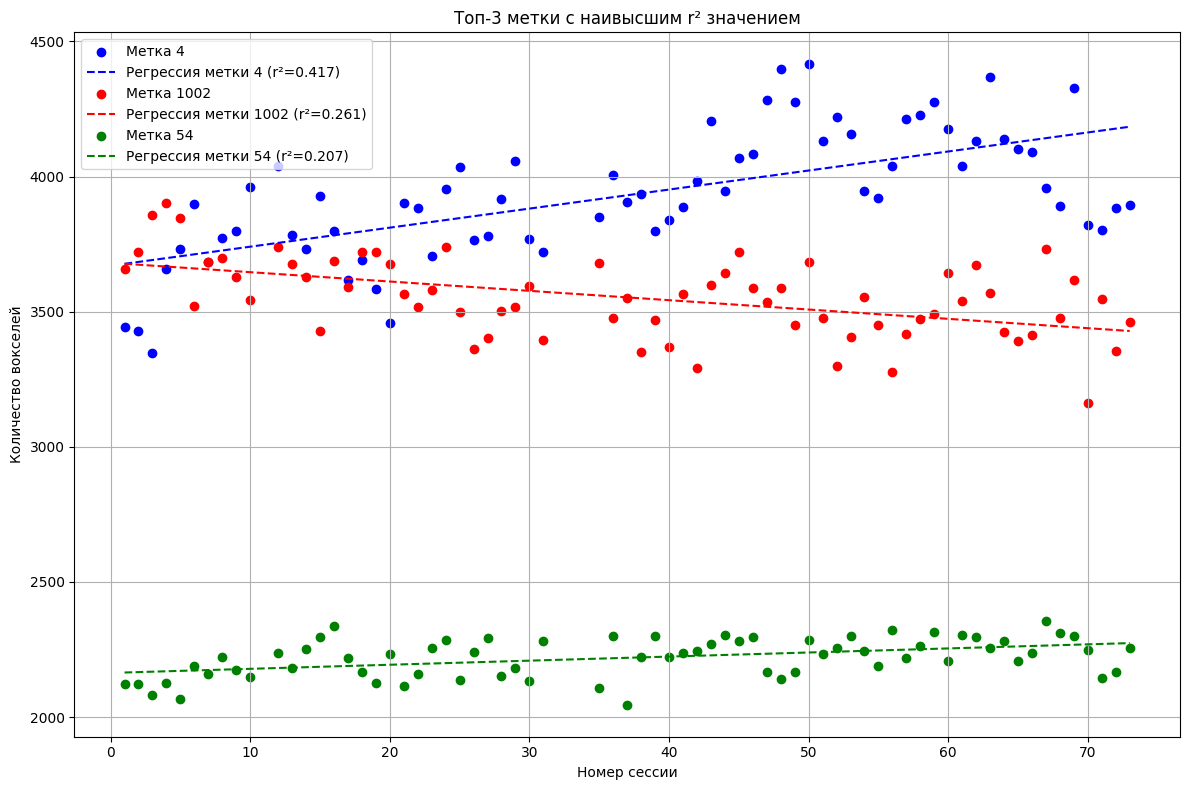

Топ-3 метки с наивысшим r² значением:
1. Метка 4: r²=0.417
2. Метка 1002: r²=0.261
3. Метка 54: r²=0.207


In [29]:
# Создаем словарь для хранения r² значений для каждой метки
r2_scores = {}

# Вычисляем r² для каждой метки
for label, data in all_labels_voxel_counts.items():
    sessions_data = [(int(session.split('-')[1]), count) for session, count in data]
    sessions_data.sort()  # Сортируем по номеру сессии
    
    if len(sessions_data) > 1:  # Убедимся, что у нас достаточно данных для регрессии
        x = np.array([session for session, _ in sessions_data])
        y = np.array([count for _, count in sessions_data])
        
        # Вычисляем линейную регрессию
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        r2_scores[label] = r_value**2

# Сортируем метки по r² значению (от высокого к низкому)
sorted_labels = sorted(r2_scores.items(), key=lambda x: x[1], reverse=True)

# Выбираем топ-3 метки с наивысшим r²
top_labels = [label for label, _ in sorted_labels[:3]]

# Создаем график
plt.figure(figsize=(12, 8))

# Цвета для разных меток
colors = ['blue', 'red', 'green']

# Строим график для каждой из топ-3 меток
for i, label in enumerate(top_labels):
    data = all_labels_voxel_counts[label]
    sessions_data = [(int(session.split('-')[1]), count) for session, count in data]
    sessions_data.sort()  # Сортируем по номеру сессии
    
    x = np.array([session for session, _ in sessions_data])
    y = np.array([count for _, count in sessions_data])
    
    plt.scatter(x, y, color=colors[i], label=f'Метка {label}')
    
    # Добавляем линию регрессии
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * x + intercept
    plt.plot(x, line, '--', color=colors[i], 
             label=f'Регрессия метки {label} (r²={r_value**2:.3f})')

plt.title('Топ-3 метки с наивысшим r² значением')
plt.xlabel('Номер сессии')
plt.ylabel('Количество вокселей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Топ-3 метки с наивысшим r² значением:")
for i, (label, r2) in enumerate(sorted_labels[:3], 1):
    print(f"{i}. Метка {label}: r²={r2:.3f}")


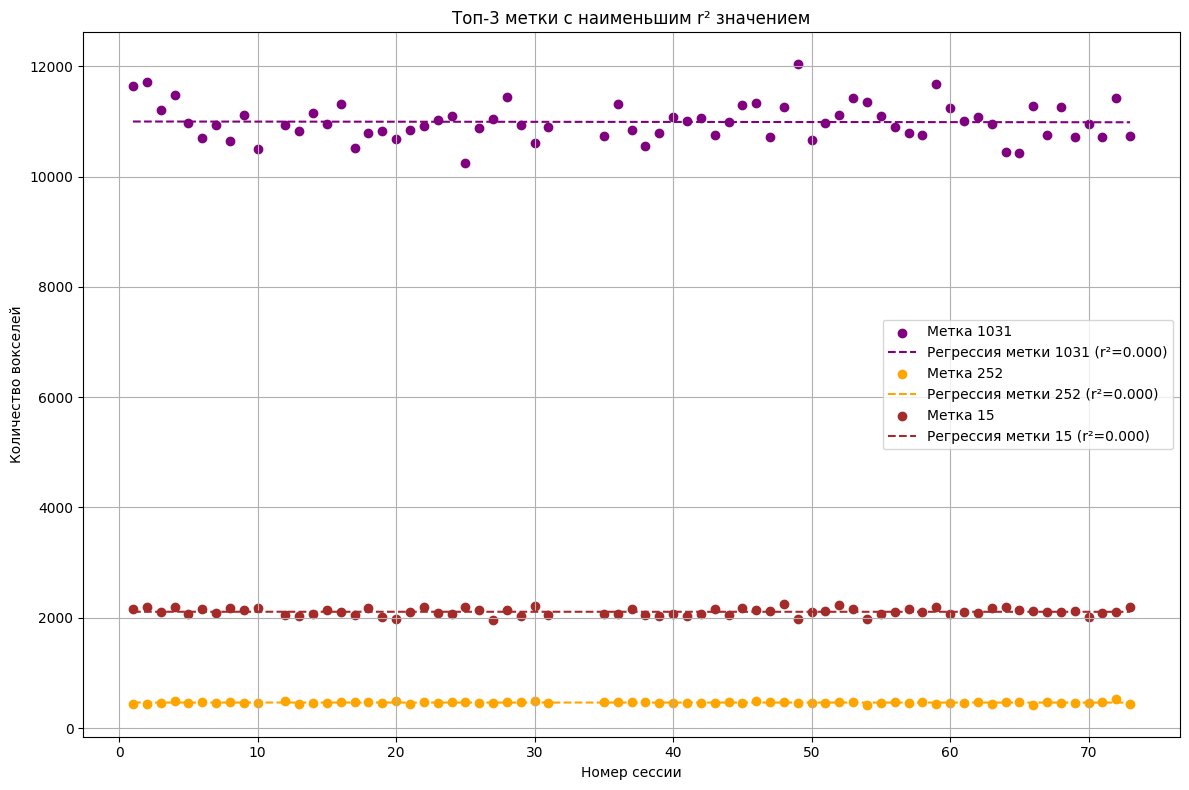

Топ-3 метки с наименьшим r² значением:
1. Метка 1031: r²=0.000
2. Метка 252: r²=0.000
3. Метка 15: r²=0.000


In [30]:
# Выбираем топ-3 метки с наименьшим r²
bottom_labels = [label for label, _ in sorted_labels[-3:]]

# Создаем график
plt.figure(figsize=(12, 8))

# Цвета для разных меток
colors = ['purple', 'orange', 'brown']

# Строим график для каждой из 3 меток с наименьшим r²
for i, label in enumerate(bottom_labels):
    data = all_labels_voxel_counts[label]
    sessions_data = [(int(session.split('-')[1]), count) for session, count in data]
    sessions_data.sort()  # Сортируем по номеру сессии
    
    x = np.array([session for session, _ in sessions_data])
    y = np.array([count for _, count in sessions_data])
    
    plt.scatter(x, y, color=colors[i], label=f'Метка {label}')
    
    # Добавляем линию регрессии
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * x + intercept
    plt.plot(x, line, '--', color=colors[i], 
             label=f'Регрессия метки {label} (r²={r_value**2:.3f})')

plt.title('Топ-3 метки с наименьшим r² значением')
plt.xlabel('Номер сессии')
plt.ylabel('Количество вокселей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Топ-3 метки с наименьшим r² значением:")
for i, (label, r2) in enumerate(sorted_labels[-3:], 1):
    print(f"{i}. Метка {label}: r²={r2:.3f}")
